Import libraries

In [308]:
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib_venn import venn3
from matplotlib.colors import to_rgb, to_hex
import seaborn as sns
import numpy as np

This Python code used to process and analyze data from an experiment involving AAVrg and cFos in two conditions: "10 minutes familiar" (n=5) **full_focus1** and "cagemate" (n=3) **full_focus2**. The data is stored in an Excel file with two sheets: full_focus1 and full_focus2. This code performs data cleaning, mapping, and organization to prepare the data for further analysis.

**Question** Is this the best way to organize this type of data? 

In [309]:
# Load the Excel file
file_path = r"C:\Users\sjs93\Downloads\cell_counts_full (2).xlsx"
excel_file = pd.ExcelFile(file_path)

# Load both sheets into separate DataFrames
sheet1 = pd.read_excel(file_path, sheet_name='full_focus1')
sheet2 = pd.read_excel(file_path, sheet_name='full_focus2')

# Rename columns for consistency
sheet1.columns = ["Slice", "Count", "Total Area", "Average Size", "%Area", "Mean", "Perim.", "Threshold"]
sheet2.columns = ["Slice", "Count", "Total Area", "Average Size", "%Area", "Mean", "Perim.", "Threshold"]

# Drop the 'Threshold' column
sheet1 = sheet1.drop(columns=['Threshold', 'Total Area', "Average Size", "%Area", "Mean", "Perim."])
sheet2 = sheet2.drop(columns=['Threshold', 'Total Area', "Average Size", "%Area", "Mean", "Perim."])

sheet1['Slice'] = sheet1['Slice'].str.lower()
sheet2['Slice'] = sheet2['Slice'].str.lower()

# Define subject-specific mappings for Channel in full_focus1 = 10 mins fam condition 
subject_mappings_full_focus1 = {
    '2_1': {'gfp': 'NAc', 'mcherry': 'MD'},
    '2_2': {'gfp': 'NAc', 'mcherry': 'MD'},
    '2_3': {'gfp': 'NAc', 'mcherry': 'MD'},
    '1_2': {'gfp': 'MD', 'mcherry': 'NAc'},
    '1_3': {'gfp': 'MD', 'mcherry': 'NAc'}
}

# Define the default mapping for full_focus2 = cagemate condition 
default_mapping_full_focus2 = {'gfp': 'MD', 'mcherry': 'NAc'}


# Function to extract markers from Slice and create projector label
def create_projector(slice_value, subject, sheet_name):
    markers = []
    if 'cfos' in slice_value:
        markers.append('cfos')
    if 'gfp' in slice_value:
        markers.append('gfp')
    if 'mcherry' in slice_value:
        markers.append('mcherry')

    if sheet_name == 'full_focus1' and subject in subject_mappings_full_focus1:
        region_mapping = subject_mappings_full_focus1[subject]
    else:
        region_mapping = default_mapping_full_focus2

    combined_markers = []
    for marker in markers:
        if marker in ['gfp', 'mcherry']:
            region = region_mapping.get(marker, 'Unknown')
            combined_markers.append(region)
        else:
            combined_markers.append(marker)
    
    # Sort combined markers alphabetically to ensure consistent ordering
    combined_markers.sort()
    
    return '+'.join(combined_markers) + '+'

# Function to extract the subject number from the Slice column
def extract_subject(slice_value):
    parts = slice_value.split('_')
    if len(parts) >= 3:
        return parts[1] + '_' + parts[2]  # Assuming the subject number is in the 2nd and 3rd position
    return 'Unknown'  # In case the slice format is unexpected

# Function to extract the region information from the Slice column
def extract_region(slice_value):
    parts = slice_value.split('_')
    if len(parts) >= 4:
        return parts[3]  # Assuming the region information is in the 4th position
    return 'Unknown'  # In case the slice format is unexpected

# Process the data for both sheets
def process_data(df, sheet_name):
    df['Slice'] = df['Slice'].astype(str)
    df['Subject'] = df['Slice'].apply(extract_subject)  # Extract the subject number
    df['Region'] = df['Slice'].apply(extract_region)    # Extract the region information
    df['Projector'] = df.apply(lambda row: create_projector(row['Slice'], row['Subject'], sheet_name), axis=1)
    return df

# Apply the updated function to both sheets. sheet1_processed = 10 min fam, sheet2_processed = cagemate 
sheet1_processed = process_data(sheet1, 'full_focus1')
sheet2_processed = process_data(sheet2, 'full_focus2')

# sheet1_processed["Count"] = sheet1_processed["Count"]
# sheet2_processed["Count"] = sheet2_processed["Count"]

sheet1_processed['Base region'] = sheet1_processed['Region'].apply(lambda x: x[1:])
sheet2_processed['Base region'] = sheet2_processed['Region'].apply(lambda x: x[1:])

sheet1_processed


,Slice,Count,Subject,Region,Projector,Base region
0,ff_2_2_aacc_1_1_cfos.png,96,2_2,aacc,cfos+,acc
1,ff_2_2_aacc_1_1_gfp.png,96,2_2,aacc,NAc+,acc
2,ff_2_2_aacc_1_1_mcherry.png,100,2_2,aacc,MD+,acc
3,ff_2_2_aacc_1_1_mcherry_gfp.png,39,2_2,aacc,MD+NAc+,acc
4,ff_2_2_aacc_1_1_mcherry_gfp_cfos.png,40,2_2,aacc,MD+NAc+cfos+,acc
...,...,...,...,...,...,...
289,ff_1_3_pil_5_1_mcherry.png,140,1_3,pil,NAc+,il
290,ff_1_3_pil_5_1_mcherry_cfos.png,111,1_3,pil,NAc+cfos+,il
291,ff_1_3_pil_5_1_gfp_cfos.png,112,1_3,pil,MD+cfos+,il
292,ff_1_3_pil_5_1_mcherry_gfp.png,110,1_3,pil,MD+NAc+,il


Counting Projectors Across Sheets
Code Explanation
The following code block combines and summarizes the counts for each projector across both full_focus1 (10 min fam) and full_focus2 (cagemate) sheets. It groups the data by the Projector column, calculates the total counts, and assigns a sheet identifier to differentiate between the two datasets.

In [285]:
projector_counts = pd.concat([sheet1_processed.groupby('Projector')['Count'].sum().reset_index().assign(sheet='full_focus1'),
                             sheet2_processed.groupby('Projector')['Count'].sum().reset_index().assign(sheet='full_focus2')])

print("Total counts for each projector by sheet:")
print(projector_counts)

Total counts for each projector by sheet:
      Projector  Count        sheet
0           MD+  11332  full_focus1
1       MD+NAc+   8859  full_focus1
2  MD+NAc+cfos+   8367  full_focus1
3      MD+cfos+   8667  full_focus1
4          NAc+  10758  full_focus1
5     NAc+cfos+   9257  full_focus1
6         cfos+   8995  full_focus1
0           MD+   3451  full_focus2
1       MD+NAc+   2378  full_focus2
2  MD+NAc+cfos+   2423  full_focus2
3      MD+cfos+   2786  full_focus2
4          NAc+   4799  full_focus2
5     NAc+cfos+   3079  full_focus2
6         cfos+   4309  full_focus2


In [286]:
projector_counts['Count'].dtype

dtype('int64')

Using marker_counts_overlap excel I plotted the totals and overlaps of cfos+, mcherry+ , and gfp+ and mapped the markers to proector regions. 

**Utilities:**

blend_colors(): A function to blend two RGB colors based on a specified ratio and return the resulting color in hexadecimal format.

plot_venn_diagram(): A function that creates a Venn diagram on a given axes object (ax) using specified counts, title, labels, and colors. It also colors different parts of the diagram based on the overlaps between three sets (cFos, MD, NAc).

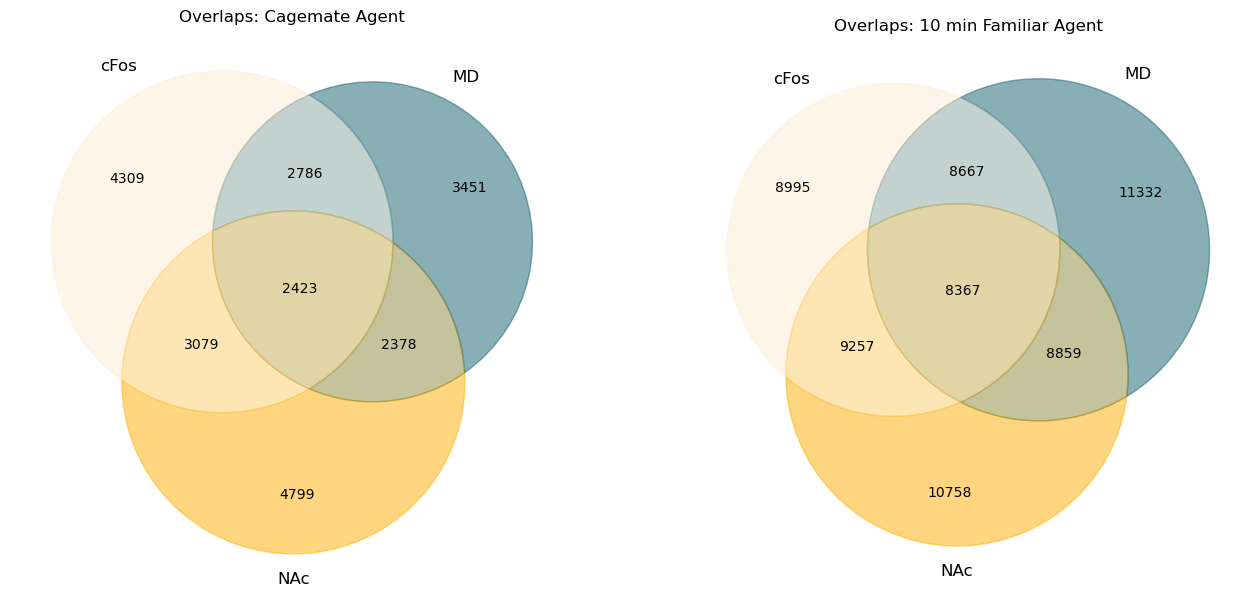

In [298]:
# Load the spreadsheet
file_path = r"C:\Users\sjs93\OneDrive - University of Florida\marker_counts_overlaps.xlsx"  # Use the correct file path
df = pd.read_excel(file_path, sheet_name=None)  # Load all sheets

# Define a function to mix two colors this needs work I am not happy with the mixing of the colors but it will do for now. 
def blend_colors(color1, color2, ratio=0.5):
    rgb1 = to_rgb(color1)
    rgb2 = to_rgb(color2)
    blended_rgb = [ratio * c1 + (1 - ratio) * c2 for c1, c2 in zip(rgb1, rgb2)]
    return to_hex(blended_rgb)

# Define a function to plot Venn diagrams with consistent colors and positions
def plot_venn_diagram(ax, counts, title, labels, colors):
    cfos, md, nac, cfos_md, cfos_nac, md_nac, cfos_md_nac = counts

    # Define the subset sizes
    subset_sizes = {
        '100': cfos,  # Only cFos
        '010': md,    # Only MD
        '001': nac,   # Only NAc
        '110': cfos_md, # cFos + MD
        '101': cfos_nac, # cFos + NAc
        '011': md_nac,  # MD + NAc
        '111': cfos_md_nac  # cFos + MD + NAc
    }

    # Plot the Venn diagram with consistent colors and positions
    venn = venn3(subsets=subset_sizes, set_labels=labels, ax=ax)

    # Assign colors to the regions
    color_map = {
        '100': colors[0],  # cFos
        '010': colors[1],  # MD
        '001': colors[2],  # NAc
        '110': blend_colors(colors[0], colors[1]),  # cFos + MD
        '101': blend_colors(colors[0], colors[2]),  # cFos + NAc
        '011': blend_colors(colors[1], colors[2]),  # MD + NAc
        '111': blend_colors(blend_colors(colors[0], colors[1]), colors[2])  # cFos + MD + NAc
    }

    for subset, color in color_map.items():
        if venn.get_patch_by_id(subset):
            venn.get_patch_by_id(subset).set_color(color)
            venn.get_patch_by_id(subset).set_alpha(0.5)
    
    ax.set_title(title)

# Define the labels to ensure consistent positioning
consistent_labels = ('cFos', 'MD', 'NAc')

# Define the specific colors (hex codes as requested)
colors = ['#FEEDD3', '#15616F', '#FFAF00']  # cFos, MD, NAc respectively

# Data extraction for counts. I  used the sheet names from my excel file ('cagemate_markers', '10min_fam')
cagemate_counts = df['cagemate_markers'].iloc[0, :7].tolist()  # Assuming columns are in required order
familiar_counts = [df['10min_fam'].iloc[0, 0], df['10min_fam'].iloc[0, 2], df['10min_fam'].iloc[0, 1], 
                   df['10min_fam'].iloc[0, 3], df['10min_fam'].iloc[0, 5], df['10min_fam'].iloc[0, 6], df['10min_fam'].iloc[0, 4]]

# Create subplots to place them side by side for comparison
fig, axs = plt.subplots(1, 2, figsize=(16, 8))

# Plot the Venn diagram for "Cagemate Agent"
plot_venn_diagram(
    ax=axs[0],
    counts=cagemate_counts, 
    title="Overlaps: Cagemate Agent", 
    labels=consistent_labels,
    colors=colors
)

# Plot the Venn diagram for "10 min Familiar Agent"
plot_venn_diagram(
    ax=axs[1],
    counts=familiar_counts, 
    title="Overlaps: 10 min Familiar Agent", 
    labels=consistent_labels,
    colors=colors
)

plt.show()

**Grouping and summing counts:** 

projector_counts.groupby('sheet'): Groups the data in the projector_counts DataFrame by the 'sheet' column. This implies that the data may span multiple sheets or categories referred to as 'sheet', and now similar entries within each sheet will be grouped together.

['Count'].sum(): This takes the 'Count' column of these grouped data and sums the counts for each 'sheet' group.

reset_index(): This resets the index of the resulting DataFrame. After the groupby operation, 'sheet' would be set as the index; reset_index() turns it back into a regular column and provides a new integer index.

rename(columns={'Count': 'Total'}): Renames the 'Count' column to 'Total' to more accurately reflect that these numbers now represent the total counts for each sheet.

**Merging Total Counts with Original Data:**

This operation merges the total_counts DataFrame back into the original projector_counts DataFrame.
The merge is performed on the 'sheet' column (specified by on='sheet'), meaning the totals calculated for each sheet will be added as a new column ('Total') to each corresponding entry of the same sheet in the original DataFrame.

**Calculating Percentages:**

This line calculates the percentage of each specific count relative to the total count for that sheet.

projector_counts['Count'] is each specific count, and projector_counts['Total'] is the total count for that particular sheet that was calculated and merged previously.
The result is multiplied by 100 to convert the fraction to a percentage.


In [311]:
# Step #1: Compute total counts per sheet
total_counts = projector_counts.groupby('sheet')['Count'].sum().reset_index().rename(columns={'Count': 'Total'})

# Step #2: Merge total counts with projector counts
# Make sure not to create multiple Total columns and remove any pre-existing ones
projector_counts.drop(columns=[col for col in projector_counts.columns if 'Total' in col], errors='ignore', inplace=True)
projector_counts = projector_counts.merge(total_counts, on='sheet')

# Step #3: Calculate percentages
projector_counts['Percentage'] = (projector_counts['Count'] / projector_counts['Total']) * 100

# Final corrected output
print("Total counts and percentages for each projector by sheet:")
print(projector_counts)

Total counts and percentages for each projector by sheet:
       Projector  Count        sheet  Percentage  Total
0            MD+  11332  full_focus1   17.108779  66235
1        MD+NAc+   8859  full_focus1   13.375104  66235
2   MD+NAc+cfos+   8367  full_focus1   12.632294  66235
3       MD+cfos+   8667  full_focus1   13.085227  66235
4           NAc+  10758  full_focus1   16.242168  66235
5      NAc+cfos+   9257  full_focus1   13.975995  66235
6          cfos+   8995  full_focus1   13.580433  66235
7            MD+   3451  full_focus2   14.858988  23225
8        MD+NAc+   2378  full_focus2   10.238967  23225
9   MD+NAc+cfos+   2423  full_focus2   10.432723  23225
10      MD+cfos+   2786  full_focus2   11.995694  23225
11          NAc+   4799  full_focus2   20.663079  23225
12     NAc+cfos+   3079  full_focus2   13.257266  23225
13         cfos+   4309  full_focus2   18.553283  23225


**Hard coded these calculation because I could not figure out how to write a fuction to do these calculation** :( SAD

    How I calculated the percentages: 

    Cagemate:

    cfos+ MD+         (2786) /  Total cFos+  MD+       (3451 + 2786 =  6237)  = 0.4466 * 100 = ~ 45 % 

    cfos+ NAc+        (3079) /  Total cFos+  NAc+      (4799 + 3079 =  7878)  = 0.3908 * 100 = ~ 39 % 

    cFos + MD + NAc   (2423) /  Total cFos+  MD+ NAc+  (6237 + 7878 = 14115)  = 0.1716 * 100 = ~ 17 %

    10 min fam: 

    cfos+ MD+         (8667) /  Total cFos+  MD+      (11332 +  8667 = 19999)  = 0.4333 * 100 = ~ 43 % 

    cfos+ NAc+        (9257) /  Total cFos+  NAc+     (10758 +  9257 = 20015)  = 0.4625 * 100 = ~ 46 % 

    cFos + MD + NAc   (8367) /  Total cFos+  MD+ NAc+ (19999 + 20015 = 40014)  =  0.2091 * 100 = ~ 21 %

data dictionary contains three keys ('Overlap Type', 'Cagemate (%)', '10 min Familiar (%)'), each associated with a list of values representing different categories and their corresponding percentages.

The data dictionary is converted into a pandas DataFrame. Which I named df and this is proabably not the best idea 


<Figure size 1400x800 with 0 Axes>

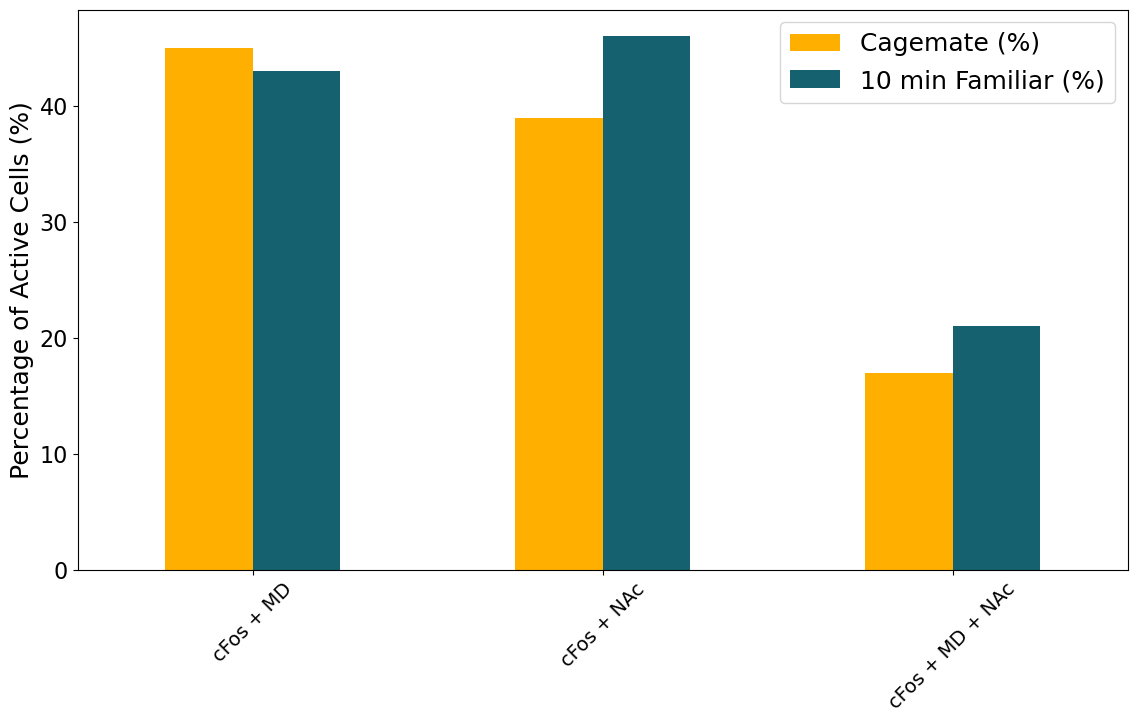

In [233]:
# Hardcode the specified data
data = {
    'Overlap Type': ['cFos + MD', 'cFos + NAc', 'cFos + MD + NAc'],
    'Cagemate (%)': [45, 39, 17],
    '10 min Familiar (%)': [43, 46, 21]
}

# Convert the data into a DataFrame
df = pd.DataFrame(data)

# Plot the results
plt.figure(figsize=(14, 8))
bars = df.plot(
    x='Overlap Type',
    kind='bar',
    color=['#FFAF00', '#15616F'],
    fontsize=14,
    figsize=(14, 8)
)
plt.ylabel('Percentage of Active Cells (%)', fontsize=18)
plt.xlabel('', fontsize=16)  # Remove the "Overlap Type" title
plt.xticks(rotation=45, fontsize=14)
plt.yticks(fontsize=16)
plt.legend(fontsize=18, loc='upper right')
plt.tight_layout()

# Adjusting figure to make sure y-axis is fully visible
plt.subplots_adjust(left=0.15, right=0.9, top=0.9, bottom=0.2)
plt.show()

Calculate Mean Cell Counts for full_focus1 ("10 min fam") and full_focus2 (cagemate):


sheet1_processed.groupby('Subject')['Count'].mean(): This line is where the main calculation occurs. 

The .groupby('Subject') function is used to group the data from sheet1_processed based on unique values in the 'Subject' column. This means that all data having the same 'Subject' are aggregated into a single group.

After grouping the data, ['Count'] specifies that from these groups, we are only interested in the 'Count' column.

.mean() then calculates the mean (average) of the 'Count' values for each group of subjects.


In [301]:
# Mean cell counts by Subject for full_focus1 (10 min fam) 
print("Mean cell counts by Subject for full_focus1:")
print(sheet1_processed.groupby('Subject')['Count'].mean())

# Mean cell counts by Subject for full_focus2 (cagemate)
print("Mean cell counts by Subject for full_focus2:")
print(sheet2_processed.groupby('Subject')['Count'].mean())

Mean cell counts by Subject for full_focus1:
Subject
1_2    269.730159
1_3    216.142857
2_1    244.285714
2_2    158.333333
2_3    240.265306
Name: Count, dtype: float64
Mean cell counts by Subject for full_focus2:
Subject
3_1    149.238095
3_2    104.125000
3_3    103.792208
Name: Count, dtype: float64


## Analysis of Cell Counts by Subject and Base Region

This analysis provides insights into how cell counts differ across subjects and specific brain regions (ACC, PL, IL), referred to as "Base regions". It handles two datasets: `full_focus1` (10 min fam) and `full_focus2` (cagemate).

### Methodology:
The data is grouped by both 'Subject' and 'Base region' to analyze the impact of these factors collectively on cell counts. The mean of these counts is calculated for each group to understand the average cell occurrences in each scenario.

### Results:
- **For `full_focus1`:**
  - The result is the average cell counts for each subject within each base region for 10 min fam

- **For `full_focus2`:**
  - The result is the average cell counts for each subject within each base region for cagemate

In [270]:
# Mean cell counts by Subject and Base region for full_focus1
print("Mean cell counts by Subject and Base region for full_focus1:")
print(sheet1_processed.groupby(['Subject', 'Base region'])['Count'].mean())

# Mean cell counts by Subject and Base region for full_focus2
print("Mean cell counts by Subject and Base region for full_focus2:")
print(sheet2_processed.groupby(['Subject', 'Base region'])['Count'].mean())

Mean cell counts by Subject and Base region for full_focus1:
Subject  Base region
1_2      acc            249.428571
         il             273.771429
         pl             310.428571
1_3      acc            247.523810
         il             199.928571
         pl             186.857143
2_1      acc            213.952381
         il             187.107143
         pl             404.142857
2_2      acc            135.714286
         il             177.942857
         pl             128.142857
2_3      acc            170.380952
         il             318.285714
         pl             215.857143
Name: Count, dtype: float64
Mean cell counts by Subject and Base region for full_focus2:
Subject  Base region
3_1      acc            141.047619
         il             169.678571
         pl             120.642857
3_2      acc             79.904762
         il             115.500000
         pl             131.285714
3_3      acc             79.523810
         il             104.678571
   

## Expanded Analysis of Cell Counts Including Projector Influence

This enhanced analysis considers not only the 'Subject' and 'Base region' as factors but also incorporates the 'Projectors' to understand their impact on cell counts across different datasets: `full_focus1` (10 min fam) and `full_focus2`(cagemate).

### Methodology:
The datasets are grouped by 'Subject', 'Base region', and 'Projectors'. The mean of these cell counts is computed for each distinct group to show any differing patterns.

### Results:
- **For `full_focus1` and `full_focus2`:**
  - Detailed results show the average cell counts across subjects, base regions, and projectors. 

In [272]:
# Mean cell counts by Subject, Base region and Projectors for full_focus1
print("Mean cell counts by Subject, Base region and Projectors for full_focus1:")
subj_mean_per_10minfam = sheet1_processed.groupby(['Subject', 'Base region', 'Projector'])['Count'].mean()
subj_mean_per_10minfam

# Mean cell counts by Subject, Base region and Projectors for full_focus2
print("Mean cell counts by Subject, Base region and Projectors for full_focus2:")
subj_mean_cagemate = sheet2_processed.groupby(['Subject', 'Base region', 'Projector'])['Count'].mean()
subj_mean_cagemate

Mean cell counts by Subject, Base region and Projectors for full_focus1:
Mean cell counts by Subject, Base region and Projectors for full_focus2:


Subject  Base region  Projector   
3_1      acc          MD+             183.666667
                      MD+NAc+         104.666667
                      MD+NAc+cfos+    114.000000
                      MD+cfos+        168.333333
                      NAc+            114.333333
                                         ...    
3_3      pl           MD+NAc+cfos+     99.250000
                      MD+cfos+         95.750000
                      NAc+            212.250000
                      NAc+cfos+       121.250000
                      cfos+           120.500000
Name: Count, Length: 63, dtype: float64

This is where I stopped Need to go through this code

Are these calculation correct? IDK

In [156]:
# Assuming 'cfos_data' is your DataFrame

# Group by region, condition, and projector and average the counts
average_counts = cfos_data.groupby(['Base Region', 'Condition', 'Projector']).agg({'Count': 'mean'}).reset_index()

# Example for '10 min fam' and 'cfos+' in 'ACC'
specific_group = average_counts[(average_counts['Condition'] == '10 min fam') & 
                                (average_counts['Base Region'] == 'ACC')]

# Calculate the sum of average counts for this specific condition and region for normalization
total_average_count = specific_group['Count'].sum()

# This method avoids SettingWithCopyWarning by using .loc to assign values on a data slice properly
if total_average_count > 0:
    grouped.loc[:, 'Percentage'] = (grouped['Count'] / grouped['Total']) * 100

print(grouped[['Projector', 'Count', 'Percentage']])

       Projector       Count  Percentage
0   MD+NAc+cfos+  161.500000   23.565175
1       MD+cfos+  170.083333   24.817607
2      NAc+cfos+  173.583333   25.328307
3          cfos+  180.166667   26.288911
4   MD+NAc+cfos+   74.444444   19.093759
5       MD+cfos+  100.000000   25.648333
6      NAc+cfos+   79.111111   20.290681
7          cfos+  136.333333   34.967227
8   MD+NAc+cfos+  172.692308   21.155296
9       MD+cfos+  193.538462   23.709009
10     NAc+cfos+  225.538462   27.629099
11         cfos+  224.538462   27.506596
12  MD+NAc+cfos+   90.166667   18.426431
13      MD+cfos+  102.750000   20.997956
14     NAc+cfos+  127.666667   26.089918
15         cfos+  168.750000   34.485695
16  MD+NAc+cfos+  264.800000   24.011607
17      MD+cfos+  272.800000   24.737033
18     NAc+cfos+  282.400000   25.607544
19         cfos+  282.800000   25.643816
20  MD+NAc+cfos+   95.857143   20.864428
21      MD+cfos+   93.285714   20.304726
22     NAc+cfos+  119.285714   25.963930
23         cfos+

c:\Users\sjs93\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\sjs93\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\sjs93\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\sjs93\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_cat

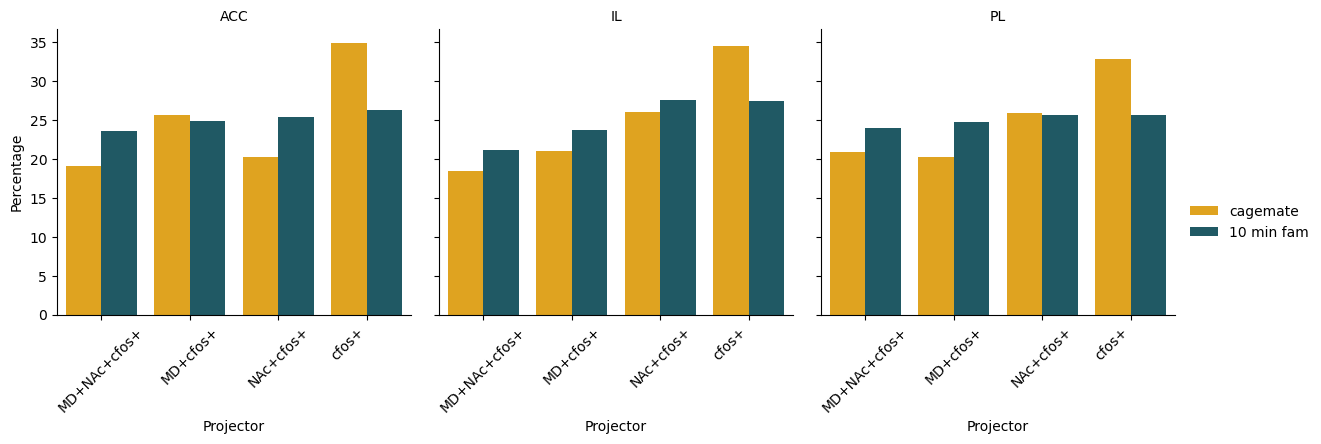

In [268]:
# Define custom colors
hue_order = ["cagemate", "10 min fam"]
palette = {"cagemate": "#FFAF00", "10 min fam": "#15616F"}

# Recreate the FacetGrid with adjusted settings
g = sns.FacetGrid(pivot_data_long, col="Base Region", height=4, aspect=1)
g.map_dataframe(sns.barplot, x='Projector', y='Percentage', hue='Condition', palette=palette, hue_order=hue_order)
g.add_legend()
g.set_titles("{col_name}")

# Rotate x-axis labels for better readability
for ax in g.axes.flat:
    for label in ax.get_xticklabels():
        label.set_rotation(45)  # Rotate labels to avoid overlap
    label.set_ha('right')  # Align the text to right for better readability

# Adjust subplot parameters to give more space
plt.subplots_adjust(bottom=0.2)

# Display the plot
plt.show()